# Basic data analysis on the background(military, major, etc) of the astronauts and the astronauts selection.

In [176]:
import pandas as pd
import unicodedata
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read the datasets
astronauts_df = pd.read_csv('astronauts.csv', encoding='latin1')
international_df = pd.read_csv('International Astronaut Database.csv', encoding='latin1')

In [178]:
# Normalize names for matching
def normalize_name(s: str):
  if pd.isna(s):
    return None
  s = unicodedata.normalize("NFKD", str(s)).encode("ascii","ignore").decode("ascii")
  s = s.lower().strip()
  for ch in [",", ".", "'", '"']: 
    s = s.replace(ch, " ")
  s = s.replace(" jr", "").replace(" sr", "")
  return " ".join(s.split())

# Convert ddd:hh:mm format to total hours
# Make sure the time data matches for both datasets
def parse_dddhhmm(s):
  """ddd:hh:mm  ---> total hours"""
  if pd.isna(s):
    return np.nan
  try:
    d,h,m = map(int, s.split(":"))
    return d*24 + h + m/60
  except Exception:
    try:
      return float(s)
    except: return np.nan

In [180]:
# Keys and helpers
astronauts_df["name_key"] = astronauts_df["Name"].map(normalize_name)
international_df["name_key"] = international_df["Name"].map(normalize_name)

astronauts_df["birth_year"] = pd.to_datetime(astronauts_df["Birth Date"], errors="coerce").dt.year

# Convert flight time to hours
international_df["total_flight_hours"] = international_df["Total Flight Time (ddd:hh:mm)"].map(parse_dddhhmm)
international_df["total_flight_days"]  = international_df["total_flight_hours"] / 24.0

In [182]:
# Merge the two datasets
merged = (astronauts_df.merge(international_df[["name_key","Country","Gender","Total Flights","total_flight_days"]],on="name_key", how="left", suffixes=("", "_iad")))

In [184]:
# Engineer the careerpath features

# 1. Flag military background
merged["is_military"] = merged["Military Branch"].fillna("").str.strip().ne("")

# 2. Map undergraduate majors to broad categories
def map_major(major):
    if pd.isna(major): return "other/unknown"
    major = str(major).lower().strip()
    if "engineer" in major: return "engineering"
    if "physics" in major: return "physical_sciences"
    if "chemistry" in major: return "physical_sciences"
    if "bio" in major: return "life_sciences"
    if "med" in major: return "medical"
    if "math" in major: return "math"
    return "other/unknown"

merged["ug_discipline"] = merged["Undergraduate Major"].map(map_major)

# 3. Create broad career pathway categories
merged["pathway"] = np.select(
    [
        merged["is_military"],
        merged["Alma Mater"].notna() & merged["Alma Mater"].astype(str).str.strip().ne(""),
        merged["Undergraduate Major"].notna() & merged["Undergraduate Major"].astype(str).str.strip().ne("")
    ],
    ["Military", "Academic", "STEM"],
    default="Other"
)


In [186]:
merged.head()

,Name,Year,Group,Status,Birth Date,Birth Place,Gender,Alma Mater,Undergraduate Major,Graduate Major,...,Death Mission,name_key,birth_year,Country,Gender_iad,Total Flights,total_flight_days,is_military,ug_discipline,pathway
0,Joseph M. Acaba,2004.0,19.0,Active,5/17/1967,"Inglewood, CA",Male,University of California-Santa Barbara; Univer...,Geology,Geology,...,NaN,joseph m acaba,1967,United States,Man,3.0,305.024306,False,other/unknown,Academic
1,Loren W. Acton,NaN,NaN,Retired,3/7/1936,"Lewiston, MT",Male,Montana State University; University of Colorado,Engineering Physics,Solar Physics,...,NaN,loren w acton,1936,NaN,NaN,NaN,NaN,False,engineering,Academic
2,James C. Adamson,1984.0,10.0,Retired,3/3/1946,"Warsaw, NY",Male,US Military Academy; Princeton University,Engineering,Aerospace Engineering,...,NaN,james c adamson,1946,NaN,NaN,NaN,NaN,True,engineering,Military
3,Thomas D. Akers,1987.0,12.0,Retired,5/20/1951,"St. Louis, MO",Male,University of Missouri-Rolla,Applied Mathematics,Applied Mathematics,...,NaN,thomas d akers,1951,NaN,NaN,NaN,NaN,True,math,Military
4,Buzz Aldrin,1963.0,3.0,Retired,1/20/1930,"Montclair, NJ",Male,US Military Academy; MIT,Mechanical Engineering,Astronautics,...,NaN,buzz aldrin,1930,United States,Man,2.0,12.078472,True,engineering,Military


# 1. Pathway distribution & outcomes

In [189]:
pathway_summary = (
    merged.assign(multi_mission = (merged["Total Flights"].fillna(0) > 1) |
                                   (merged["Space Flights"].fillna(0) > 1))
          .groupby("pathway", dropna=False)
          .agg(astronauts=("Name","count"),
               avg_total_flights=("Total Flights","mean"),
               pct_multi_mission=("multi_mission","mean"),
               avg_total_days_in_space=("total_flight_days","mean"))
          .reset_index()
)

# 2. Military vs civilian comparison

In [192]:
military_vs_civil = (
    merged.groupby("is_military")
          .agg(astronauts=("Name","count"),
               avg_total_flights=("Total Flights","mean"),
               avg_days_in_space=("total_flight_days","mean"))
          .reset_index()
)

# 3. Top undergraduate major choices

In [195]:
major_summary = (
    merged.assign(UndergraduateMajor = merged["Undergraduate Major"].astype(str).str.strip())
          .groupby("Undergraduate Major")
          .agg(astronauts=("Name","count"),
               avg_total_flights=("Total Flights","mean"),
               avg_days_in_space=("total_flight_days","mean"))
          .sort_values("astronauts", ascending=False)
          .head(15)
          .reset_index()
)

# Making separate csv files for outcomes

In [198]:
# Career pathway summary
pathway_summary.to_csv("career_pathway_summary.csv", index=False)

In [200]:
# Top Undergraduate Majors
major_summary.index = major_summary.index + 1
major_summary.index.name = "Rank"
major_summary.to_csv("top_undergraduate_majors_outcomes.csv")

In [202]:
# Military vs Civilian Outcomes
military_vs_civil.to_csv("military_vs_civil_outcomes.csv", index=False)

In [204]:
# Merged Dataset
merged.to_csv("merged_astronauts_dataset.csv", index=False)

test

# Primary Research Question: Whether non-military astronauts (is_military=False) have had increasing opportunity over time and comparable or improving mission performance

In [208]:
# Filter only the relevant columns and drop rows with missing 'Year'
df_clean = merged[['Year', 'is_military', 'Space Flight (hr)', 'Space Walks (hr)', 'Total Flights']].dropna(subset=['Year'])

# Convert Year to integer
df_clean['Year'] = df_clean['Year'].astype(int)


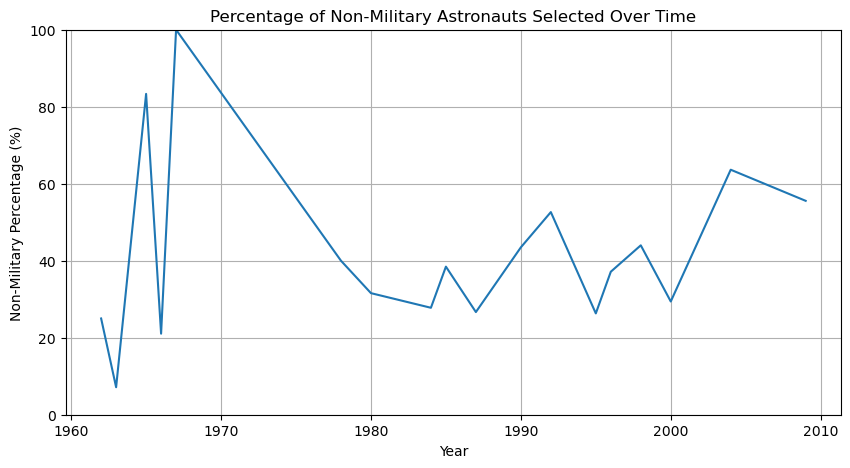

In [210]:
# Count non-military astronauts per year
non_military_by_year = df_clean[df_clean['is_military'] == False].groupby('Year').size()

# Count all astronauts per year
total_by_year = df_clean.groupby('Year').size()

# Compute percentage
non_military_percentage = (non_military_by_year / total_by_year) * 100

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(x=non_military_percentage.index, y=non_military_percentage.values)
plt.title("Percentage of Non-Military Astronauts Selected Over Time")
plt.xlabel("Year")
plt.ylabel("Non-Military Percentage (%)")
plt.ylim(0, 100)  # Keep it within [0, 100]%
plt.grid(True)
plt.show()


In [212]:
grouped = df_clean.groupby('is_military')[['Space Flight (hr)', 'Space Walks (hr)', 'Total Flights']].mean()
print(grouped)

             Space Flight (hr)  Space Walks (hr)  Total Flights
is_military                                                    
False              1441.056911         11.219512       2.480000
True               1262.294686          6.625604       2.568627


## Correlation Analysis of Astronaut Background Factors with Space Flights and Space Walks (with One-Hot Encoded Categorical Variables)

In [215]:
# STEP 1: Select relevant columns
columns_of_interest = [
    'Year', 'birth_year', 'Space Flights', 'Space Walks',
    'is_military', 'Gender', 'ug_discipline', 'Military Rank', 'Military Branch'
]

# STEP 2: Copy the relevant columns
df_corr = merged[columns_of_interest].copy()

# STEP 3: Convert boolean to numeric
df_corr['is_military'] = df_corr['is_military'].astype(int)

# STEP 4: Drop rows with missing target values
df_corr = df_corr.dropna(subset=['Space Flights', 'Space Walks'])

# STEP 5: One-hot encode the categorical variables (drop_first=True to avoid multicollinearity)
categorical_cols = ['Gender', 'ug_discipline', 'Military Rank', 'Military Branch']
df_encoded = pd.get_dummies(df_corr, columns=categorical_cols, drop_first=True)

# STEP 6: Compute correlation matrix
correlation_matrix = df_encoded.corr()

# STEP 7: Extract and sort correlations with the targets
correlation_with_targets = correlation_matrix[['Space Flights', 'Space Walks']].sort_values(by='Space Flights', ascending=False)

# Step 8: Filter to keep only correlations ≥ |0.1|
correlation_filtered = correlation_with_targets[
    (correlation_with_targets['Space Flights'].abs() >= 0.1) |
    (correlation_with_targets['Space Walks'].abs() >= 0.1)
]

# Display result
print(correlation_filtered)

                                        Space Flights  Space Walks
Space Flights                                1.000000     0.257073
Space Walks                                  0.257073     1.000000
Military Branch_US Navy (Retired)            0.150735    -0.031367
Military Branch_US Air Force (Retired)       0.139728    -0.105198
Military Rank_Colonel                        0.114880    -0.028395
Military Rank_Lieutenant General             0.112367    -0.027278
birth_year                                   0.093195     0.222490
Year                                         0.036420     0.210073
Gender_Male                                 -0.010142     0.127017
Military Rank_Major                         -0.130665    -0.072324
ug_discipline_other/unknown                 -0.143808     0.049445
Military Rank_Commander                     -0.154431    -0.016048
Military Branch_US Navy                     -0.180629     0.039546


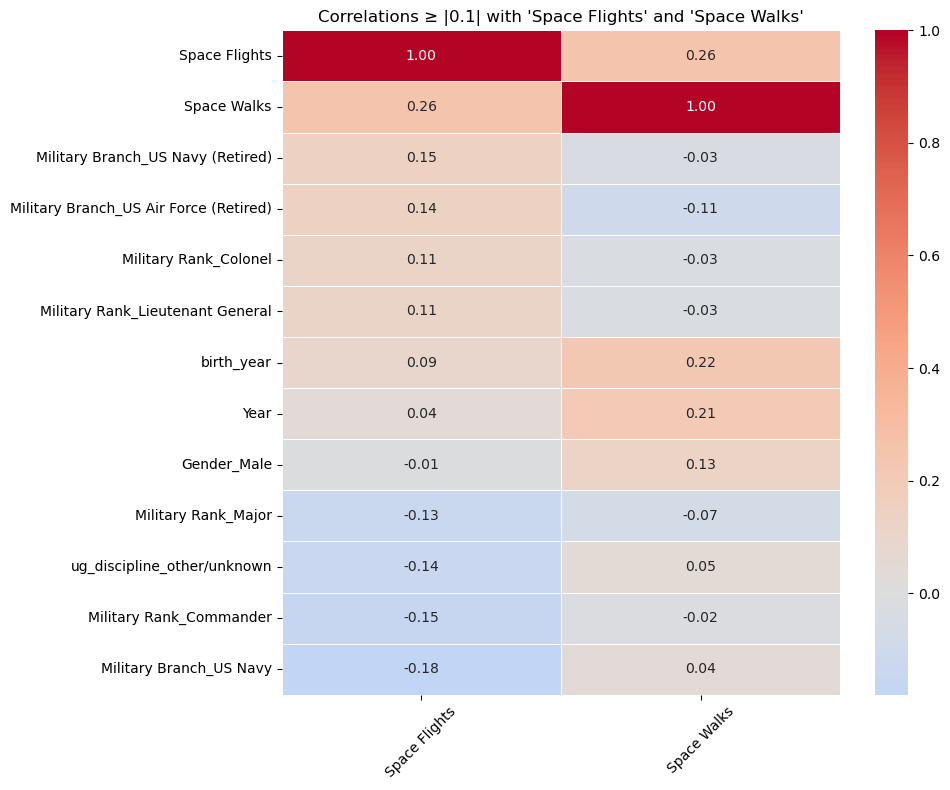

In [217]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_filtered,
    annot=True,
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    fmt=".2f"
)
plt.title("Correlations ≥ |0.1| with 'Space Flights' and 'Space Walks'")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Finalized Research Question: What factors are predictive of an individual’s assigned role in the aerospace domain?

## Factor #1: Gender

Gender_Male has a correlation of 0.127017 with Space Walks, which is above the 0.1 threshold.

In [222]:
# Count number of females
female_count = merged[merged['Gender'] == 'Female'].shape[0]

# Count total number of non-missing gender entries
total_gender_count = merged['Gender'].notna().sum()

# Calculate percentage
female_percentage = (female_count / total_gender_count) * 100

# Display result
print(f"Number of Female Astronauts: {female_count}")
print(f"Percentage of Female Astronauts: {female_percentage:.2f}%")

Number of Female Astronauts: 50
Percentage of Female Astronauts: 14.01%


Since women make up a small minority of the sample, their statistical contribution to correlation or predictive models is limited.
- With such a small group size, results for Gender_Female are likely unstable or not statistically significant.
- To avoid misleading conclusions, we use Gender_Male as the reference baseline for analysis, while noting the gender imbalance.

## Factor #2: Mission Age

### Feature Importance Analysis for Predicting Space Flights Using Random Forest

In [227]:
from sklearn.ensemble import RandomForestRegressor

X = df_encoded.drop(columns=['Space Flights', 'Space Walks'])
y = df_encoded['Space Flights']  # or 'Space Walks'

model = RandomForestRegressor()
model.fit(X, y)

importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances.head(10))

Year                                 0.441692
birth_year                           0.236471
Military Branch_US Navy              0.035149
Military Branch_US Navy (Retired)    0.027973
is_military                          0.025822
Gender_Male                          0.024876
Military Rank_Captain                0.024430
ug_discipline_physical_sciences      0.023913
ug_discipline_other/unknown          0.023316
Military Rank_Commander              0.019589
dtype: float64


Interpretation:
1. Year
   - The era in which an astronaut was selected has the biggest influence on how many flights they got. Earlier astronauts (1960s–1980s) often had more opportunities because the shuttle flew frequently. More recent astronauts face fewer missions due to fewer launches (post-Shuttle era).
2. birth_year
   - Older astronauts may have been selected in high-flight decades, younger ones in low-flight decades.

### Mission Age

We define Mission Age as the difference between Mission Year and Birth Year, representing the age at which an astronaut completed a mission.

## Factor #3: Military

Military Branch_US Navy (Retired), Military Branch_US Air Force (Retired), Military Rank_Colonel, Military Rank_Lieutenant General, Military Rank_Major, Military Rank_Commander, and Military Branch_US Navy all have a correlation above the 0.1 threshold.

## Factor #4: Undergraduate Discipline

In the previous data cleaning process, we defined ug_discipline_other/unknown as all undergraduate disciplines outside of engineering and science, including (but not limited to) education, business, and philosophy. This variable shows a moderate negative correlation of -0.14 with Space Flights, indicating that having a non-engineering or non-science background is associated with fewer spaceflights. This suggests that undergraduate discipline is another factor influencing one of the most important indicators of astronaut performance — mission count (Space Flights).